In [110]:
import torch
from datasets import load_dataset

print("PyTorch Version : {}".format(torch.__version__))
print("Cuda Available : {}".format(torch.cuda.is_available()))

PyTorch Version : 2.1.2+cu121
Cuda Available : True


# 1. Prepare the dataset

In [111]:
# 0.1 - 10%, 0.2 - 20%, ..., 1.0 - 100%
PERCENT_OF_TRAINING_DATA = 1.0
RANDOM_STATE = 42

In [112]:
import pandas as pd
from torch.utils.data import Dataset

df = pd.read_csv('data/SUBJ/data.tsv', sep='\t')
text_data = df['text'].tolist()
labels = df['label'].tolist()

In [113]:
class TextClassificationDataset(Dataset):
    def __init__(self, text_data, labels):
        self.text_data = text_data
        self.labels = labels

    def __len__(self):
        return len(self.text_data)

    def __getitem__(self, idx):
        text = self.text_data[idx]
        label = self.labels[idx]
        return (label, text)


In [114]:
# Split dataset into train, validation and test
from sklearn.model_selection import train_test_split


train_df, test_df = train_test_split(df, test_size=0.1, random_state=RANDOM_STATE, stratify=df['label'])
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=RANDOM_STATE, stratify=train_df['label'])

if PERCENT_OF_TRAINING_DATA < 1:
    train_df, notused_df = train_test_split(train_df, test_size=(1 - PERCENT_OF_TRAINING_DATA), random_state=RANDOM_STATE, stratify=train_df['label'])


print('#train_samples:', train_df.shape[0])
print('#val_samples:', val_df.shape[0])
print('#test_samples:', test_df.shape[0])


#train_samples: 8100
#val_samples: 900
#test_samples: 1000


In [115]:
from torchtext.data.utils import get_tokenizer
from transformers import logging, AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
print(tokenizer("here is an example"))
tokenizer("here is an example")['input_ids']

{'input_ids': [101, 2182, 2003, 2019, 2742, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1]}


[101, 2182, 2003, 2019, 2742, 102]

In [116]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from transformers import logging, AutoTokenizer, AutoModel


# Convert a dataframe to a torch dataset
train_dataset = TextClassificationDataset(train_df['text'].tolist(), train_df['label'].tolist())
test_dataset = TextClassificationDataset(test_df['text'].tolist(), test_df['label'].tolist())
val_dataset = TextClassificationDataset(val_df['text'].tolist(), val_df['label'].tolist())

train_iter = iter(train_dataset)

def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)


In [117]:
text_pipeline = lambda x: tokenizer(x)['input_ids']
label_pipeline = lambda x: int(x)

In [118]:
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for _label, _text in batch:
        label_list.append(label_pipeline(_label))
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
        offsets.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list.to(device), text_list.to(device), offsets.to(device)

In [119]:
from torch import nn

class TextClassificationModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=False)
        self.fc = nn.Linear(embed_dim, num_class)
        self.dropout = nn.Dropout(p=0.5)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        embedded = self.dropout(embedded)
        return self.fc(embedded)

In [120]:
num_class = 2
vocab_size = len(tokenizer)
emsize = 64
model = TextClassificationModel(vocab_size, emsize, num_class).to(device)

In [121]:
total_params = sum(p.numel() for p in model.parameters())
total_params_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of parameters: ", total_params)
print("Number of trainable parameters: ", total_params_trainable)

Number of parameters:  1953538
Number of trainable parameters:  1953538


In [122]:
import time

def train(dataloader):
    model.train()
    total_acc, total_count = 0, 0
    log_interval = 500
    start_time = time.time()

    for idx, (label, text, offsets) in enumerate(dataloader):
        optimizer.zero_grad()
        predicted_label = model(text, offsets)
        loss = criterion(predicted_label, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        total_acc += (predicted_label.argmax(1) == label).sum().item()
        total_count += label.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print(
                "| epoch {:3d} | {:5d}/{:5d} batches "
                "| accuracy {:8.3f}".format(
                    epoch, idx, len(dataloader), total_acc / total_count
                )
            )
            total_acc, total_count = 0, 0
            start_time = time.time()


def evaluate(dataloader):
    model.eval()
    total_acc, total_count = 0, 0
    total_loss = 0
    with torch.no_grad():
        for idx, (label, text, offsets) in enumerate(dataloader):
            predicted_label = model(text, offsets)
            loss = criterion(predicted_label, label)

            total_loss += loss.item()
            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc / total_count, total_loss / total_count


In [123]:
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset

# Hyperparameters
EPOCHS = 10
LR = 1e-3
BATCH_SIZE = 16

criterion = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=LR)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
total_accu = None

train_dataloader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch
)

test_dataloader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch
)

valid_dataloader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch
)

# Define the dictionary "history" that will collect key performance indicators during training
history = {}
history["epoch"]=[]
history["train_loss"]=[]
history["valid_loss"]=[]
history["train_accuracy"]=[]
history["valid_accuracy"]=[]

for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train(train_dataloader)
    accu_train, loss_train = evaluate(train_dataloader)
    accu_val, loss_val = evaluate(valid_dataloader)
    if total_accu is not None and total_accu > accu_val:
        scheduler.step()
    else:
        total_accu = accu_val
    print("-" * 59)
    print(
        "| end of epoch {:3d} | time: {:5.2f}s | "
        "valid accuracy {:8.3f} ".format(
            epoch, time.time() - epoch_start_time, accu_val
        )
    )
    print("-" * 59)
      # Populate history
    history["epoch"].append(epoch+1)
    history["train_loss"].append(loss_train)
    history["valid_loss"].append(loss_val)
    history["train_accuracy"].append(accu_train)
    history["valid_accuracy"].append(accu_val)    

| epoch   1 |   500/  507 batches | accuracy    0.749
-----------------------------------------------------------
| end of epoch   1 | time:  2.65s | valid accuracy    0.864 
-----------------------------------------------------------
| epoch   2 |   500/  507 batches | accuracy    0.897
-----------------------------------------------------------
| end of epoch   2 | time:  2.62s | valid accuracy    0.888 
-----------------------------------------------------------
| epoch   3 |   500/  507 batches | accuracy    0.928
-----------------------------------------------------------
| end of epoch   3 | time:  2.60s | valid accuracy    0.900 
-----------------------------------------------------------
| epoch   4 |   500/  507 batches | accuracy    0.946
-----------------------------------------------------------
| end of epoch   4 | time:  2.65s | valid accuracy    0.900 
-----------------------------------------------------------
| epoch   5 |   500/  507 batches | accuracy    0.958
------

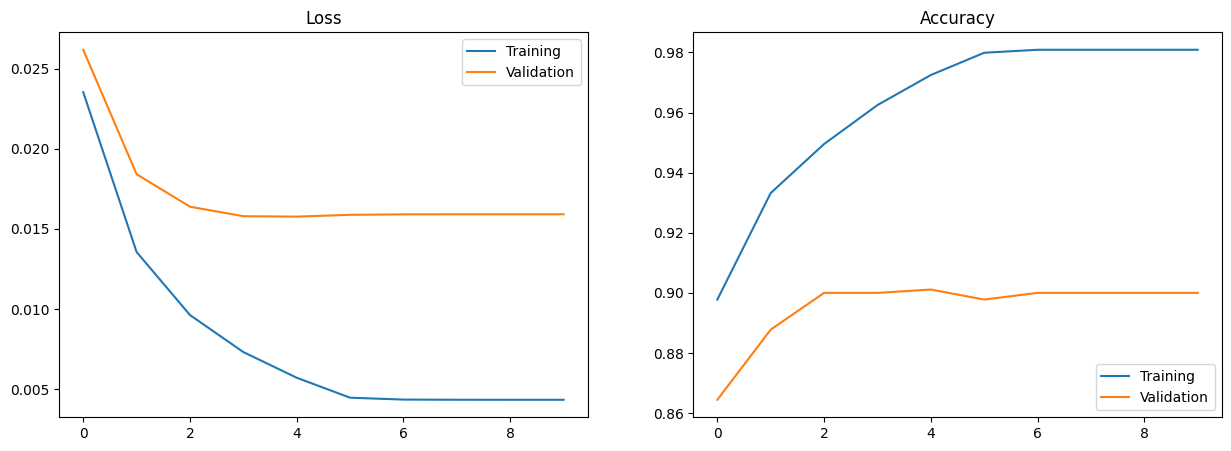

In [124]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
ax[0].set(title='Loss')
ax[0].plot(history['train_loss'], label='Training')
ax[0].plot(history['valid_loss'], label='Validation')
ax[0].legend(loc="upper right")

ax[1].set(title='Accuracy')
ax[1].plot(history['train_accuracy'], label='Training')
ax[1].plot(history['valid_accuracy'], label='Validation')
ax[1].legend(loc="lower right")

In [125]:
text_labels = {1: "Subjective", 0: "Objective"}

def predict(text, text_pipeline):
    with torch.no_grad():
        text = torch.tensor(text_pipeline(text))
        output = model(text, torch.tensor([0]))
        print(output)
        return output.argmax(1).item()

model = model.to(device)

In [126]:
def evaluateF1(dataloader):
    model.eval()
    total_acc, total_count = 0, 0
    TP = 0
    FP = 0
    TN = 0
    FN = 0
    with torch.no_grad():
        for idx, (label, text, offsets) in enumerate(dataloader):
            predicted_label = model(text, offsets)
            plabel = predicted_label.argmax(1)
       
            label_list = label.tolist()
            predicted_label_list = plabel.tolist()

            for i in range(len(label_list)):
                if label_list[i] == 1:
                    if predicted_label_list[i] == 1:
                        TP += 1
                    else:
                        FN += 1
                else:
                    if predicted_label_list[i] == 0:
                        TN += 1
                    else:
                        FP += 1
            # print(label_list,'-->', predicted_label_list)
            # loss = criterion(predicted_label.argmax(1), label)
            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    print('TP:', TP)
    print('FN:', FN)
    print('FP:', FP)
    print('TN:', TN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    F1 = 2 * precision * recall / (precision + recall)
    accuracy = total_acc / total_count
    print('accuracy:', accuracy)
    print('precision:', precision)
    print('recall:', recall)
    print('F1:', F1)
    print('{:10.4f},{:10.4f},{:10.4f},{:10.4f}'.format(accuracy, precision, recall, F1))
    return total_acc / total_count

In [127]:
print("Checking the results on SUBJ test dataset.")
evaluateF1(test_dataloader)

Checking the results on SUBJ test dataset.
TP: 468
FN: 32
FP: 42
TN: 458
accuracy: 0.926
precision: 0.9176470588235294
recall: 0.936
F1: 0.9267326732673268
    0.9260,    0.9176,    0.9360,    0.9267


0.926

**Evaluate on tasksource**

In [128]:
df = pd.read_csv('data/tasksource/test.csv')
df.head()

,Sentence,Label,Solved conflict
0,The fourth focused on Republican criticism of ...,OBJ,False
1,At least a dozen GOP-controlled state legislat...,OBJ,False
2,It must explicitly act for the benefit of whit...,SUBJ,False
3,But the MSM does have a point about GOP rhetor...,OBJ,False
4,These issues include punishing Sanctuary Citie...,OBJ,False


In [129]:
label2id = {"SUBJ": 1, "OBJ": 0}

# tasksource
# remove the last column from a dataframe
df = df.iloc[:, :-1]
# rename the first column of the dataframe
df = df.rename(columns={"Sentence": "text", "Label": "label"})

df['label'] = df['label'].apply(lambda x: label2id[x])
df.head()

,text,label
0,The fourth focused on Republican criticism of ...,0
1,At least a dozen GOP-controlled state legislat...,0
2,It must explicitly act for the benefit of whit...,1
3,But the MSM does have a point about GOP rhetor...,0
4,These issues include punishing Sanctuary Citie...,0


In [130]:
labels = df['label'].to_list()
texts = df['text'].to_list()
dataset = TextClassificationDataset(texts, labels)
test_dataloader = DataLoader(
    dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch
)
print("Checking the results on TASKSOURCE test dataset.")
evaluateF1(test_dataloader)

Checking the results on TASKSOURCE test dataset.
TP: 65
FN: 48
FP: 48
TN: 58
accuracy: 0.5616438356164384
precision: 0.5752212389380531
recall: 0.5752212389380531
F1: 0.5752212389380531
    0.5616,    0.5752,    0.5752,    0.5752


0.5616438356164384

**Evaluate on bard dataset**

In [131]:
# Load the dataset

df = pd.read_csv('data/bard.csv')
df.shape
# df.head()

(100, 2)

In [132]:
# Evaluate the model on the dataset

labels = df['label'].to_list()
texts = df['text'].to_list()

dataset = TextClassificationDataset(texts, labels)
test_dataloader = DataLoader(
    dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch
)


print("Checking the results on BARD test dataset.")
evaluateF1(test_dataloader)

Checking the results on BARD test dataset.
TP: 41
FN: 9
FP: 24
TN: 26
accuracy: 0.67
precision: 0.6307692307692307
recall: 0.82
F1: 0.7130434782608696
    0.6700,    0.6308,    0.8200,    0.7130


0.67

**Evaluate on AI21 dataset**

In [133]:
# Load the dataset

df = pd.read_csv('data/ai21.csv')
df.shape
# df.head()

(100, 2)

In [134]:
# Evaluate the model on the dataset

labels = df['label'].to_list()
texts = df['text'].to_list()

dataset = TextClassificationDataset(texts, labels)
test_dataloader = DataLoader(
    dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch
)


print("Checking the results on AI21 test dataset.")
evaluateF1(test_dataloader)

Checking the results on AI21 test dataset.
TP: 25
FN: 25
FP: 14
TN: 36
accuracy: 0.61
precision: 0.6410256410256411
recall: 0.5
F1: 0.5617977528089888
    0.6100,    0.6410,    0.5000,    0.5618


0.61